In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from PIL import Image
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # thuat toan toi uu hoa
from keras.models import load_model, model_from_json
import json, codecs

In [ ]:
benign_train = '/content/drive/MyDrive/AI_Application/dataset/train/benign'
malignant_train = '/content/drive/MyDrive/AI_Application/dataset/train/malignant'

benign_test = '/content/drive/MyDrive/AI_Application/dataset/test/benign'
malignant_test = '/content/drive/MyDrive/AI_Application/dataset/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(benign_train, filename)) for filename in os.listdir(benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(malignant_train, filename)) for filename in os.listdir(malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(benign_test, filename)) for filename in os.listdir(benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(malignant_test, filename)) for filename in os.listdir(malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [ ]:
print(X_train.shape[0])

2637


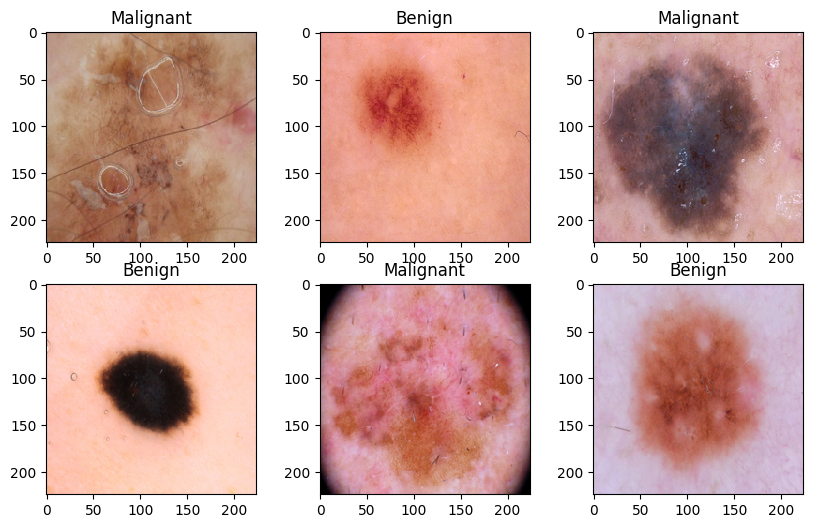

In [ ]:
# Display first 6 images of moles, and how they are classified
fig = plt.figure(figsize=(10, 6))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [ ]:
# normalize to range [0,1]
X_train = X_train/255.
X_test = X_test/255.
num_classes = 2
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
print('Train data: X={} y={}'.format(X_train.shape, y_train.shape))
print('Test data : X={} y={}'.format(X_test.shape, y_test.shape))

Train data: X=(2637, 224, 224, 3) y=(2637, 2)
Test data : X=(660, 224, 224, 3) y=(660, 2)


In [ ]:
def prepare_model():
  model = Sequential() # thể hiện việc các layer được xây dựng theo đúng thứ tự
  #
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                  activation ='relu', input_shape = (224,224,3)))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  #
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))
  #
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))
  #
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.2))

  #
  model.add(Flatten()) # convert a matrix to a vector.
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = "softmax"))

  model.summary()

  # optimize object
  optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

  model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
# Set a learning rate annealer
callbacks = [ReduceLROnPlateau(monitor='accuracy',
                               patience=3, # sau 3 epochs thì lr=0.1*lr
                               verbose=1,
                               factor=0.1,
                               mode='max',
                               min_learning_rate=1e-5)
]

In [ ]:
# Batch size: số lượng mẫu mỗi lần cập nhật gradient
# Epoch: 1 epoch là một lần duyệt qua hết các dữ liệu trong tập huấn luyện
# Iterations: số lượng các Batch size mà mô hình phải duyệt trong 1 epoch

model = prepare_model()
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    epochs= 64, batch_size= 64, verbose=1,
                    callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


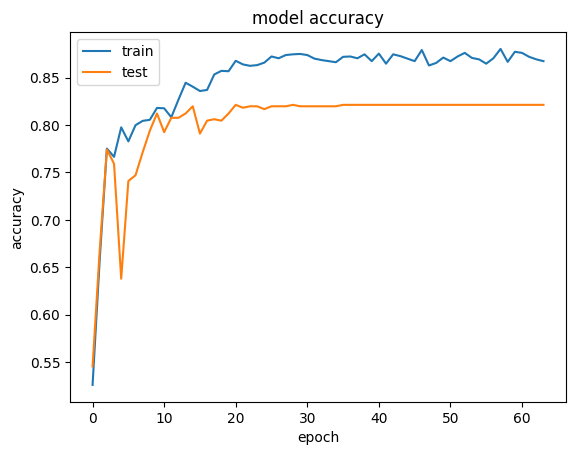

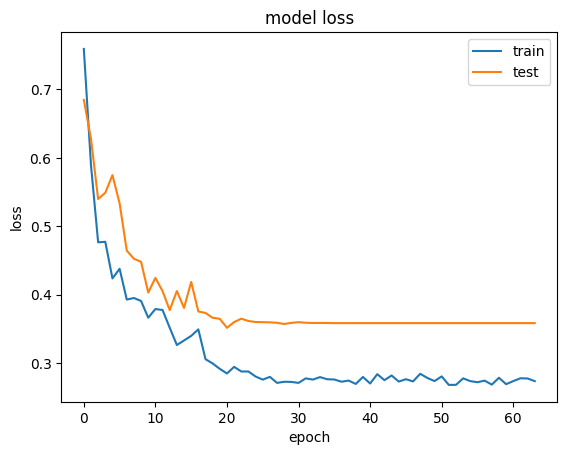

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
with open('/content/drive/MyDrive/AI_Application/dataset/model.json', 'rb') as json_file:
  loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/content/drive/MyDrive/AI_Application/dataset/model.h5')

In [ ]:
# Testing model on test data to evaluate
y_pred = loaded_model.predict(X_test)

acc = accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))
print('Accuracy: {:.4f}%'.format(acc*100))
print(y_pred)

21/21 [==============================] - 1s 15ms/step
Accuracy: 84.0909%
[[8.0007404e-02 9.1999257e-01]
 [1.7078592e-02 9.8292142e-01]
 [9.9997544e-01 2.4521114e-05]
 ...
 [3.4008759e-01 6.5991235e-01]
 [2.0318930e-06 9.9999797e-01]
 [1.5698096e-01 8.4301907e-01]]


1/1 [==============================] - 0s 311ms/step


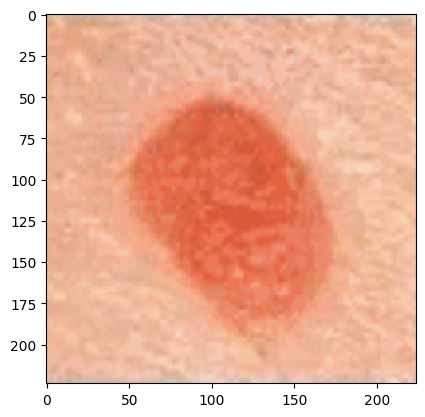

[0]


In [ ]:
read1 = lambda imname: np.asarray(Image.open(imname).resize((224,224)).convert("RGB"))

test_path = '/content/benign1.png'
ims_test = [read1(os.path.join(test_path))]
test = np.array(ims_test, dtype='uint8')

# Testing model on test data to evaluate
pred = loaded_model.predict(test)
pred=np.argmax(pred, axis=1)

# Display first 6 images of moles, and how they are classified
#fig = plt.figure(figsize=(10, 6))

plt.imshow(test[0], interpolation='nearest')
plt.show()

print(pred)

In [ ]:
K.clear_session()
del model
del history

NameError: ignored

In [ ]:
# define 4-fold cross validation test harness
kfold = KFold(n_splits=4, shuffle=True, random_state=1)

cvscores = []
histories = []

for train, test in kfold.split(X_train, y_train):
    # prepare model
    model = prepare_model()
    # Fit the model
    history = model.fit(X_train[train], y_train[train], validation_data = (X_train[test], y_train[test]),
                        epochs=64, batch_size=64, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%\n" % (model.metrics_names[1], scores[1]*100))
    # stores scores
    cvscores.append(scores[1] * 100)
    histories.append(history)
    K.clear_session()
    del model

print("Accuracy: %.2f%% (+/- %.2f%%), n = %d" % (np.mean(cvscores), np.std(cvscores), len(cvscores)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [ ]:
# Fitting model to all data
model = prepare_model()

model.fit(X_train, y_train, epochs=64, batch_size= 64,
          verbose=1, callbacks=callbacks)

# Testing model on test data to evaluate
y_pred = model.predict(X_test)

acc = accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))
print('Accuracy: {:.4f}%'.format(acc*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

In [ ]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Clear memory, because of memory overload
del model
K.clear_session()

# ResNet50

Epoch 1/50
23/23 - 47s - loss: 0.6217 - accuracy: 0.6902 - val_loss: 0.6941 - val_accuracy: 0.5014 - lr: 1.0000e-05 - 47s/epoch - 2s/step
Epoch 2/50
23/23 - 31s - loss: 0.5065 - accuracy: 0.7809 - val_loss: 0.7052 - val_accuracy: 0.5014 - lr: 1.0000e-05 - 31s/epoch - 1s/step
Epoch 3/50
23/23 - 31s - loss: 0.4348 - accuracy: 0.7997 - val_loss: 0.7389 - val_accuracy: 0.5014 - lr: 1.0000e-05 - 31s/epoch - 1s/step
Epoch 4/50
23/23 - 31s - loss: 0.3824 - accuracy: 0.8227 - val_loss: 0.8016 - val_accuracy: 0.5014 - lr: 1.0000e-05 - 31s/epoch - 1s/step
Epoch 5/50
23/23 - 31s - loss: 0.3617 - accuracy: 0.8311 - val_loss: 0.8593 - val_accuracy: 0.5014 - lr: 1.0000e-05 - 31s/epoch - 1s/step
Epoch 6/50
23/23 - 31s - loss: 0.3379 - accuracy: 0.8388 - val_loss: 0.9553 - val_accuracy: 0.5014 - lr: 1.0000e-05 - 31s/epoch - 1s/step
Epoch 7/50
23/23 - 31s - loss: 0.3363 - accuracy: 0.8458 - val_loss: 1.0346 - val_accuracy: 0.5014 - lr: 1.0000e-05 - 31s/epoch - 1s/step
Epoch 8/50
23/23 - 31s - loss: 0.3

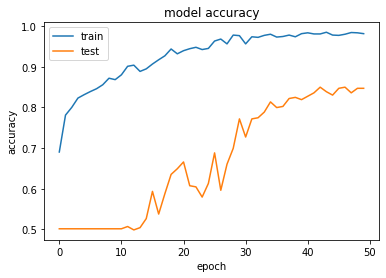

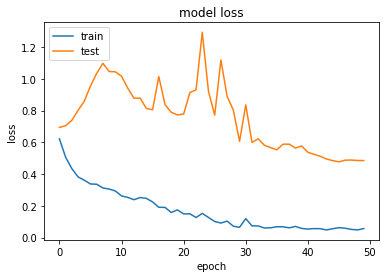

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=(224, 224, 3),
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2,
                    callbacks=callbacks
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=callbacks
         )


Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.

Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.9999988758398e-14.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999998977483753e-16.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999998977483754e-17.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999010570977e-19.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999424161285e-20.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999682655225e-21.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.999999682655225e-22.

Epoch 00041: ReduceLROnPlateau

In [ ]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)

# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

0.8459821428571429


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk
